In [2]:
import os
import sys
import numpy as np
import matplotlib
matplotlib.use('nbagg')
from matplotlib import style
style.use('ggplot')
import matplotlib.pyplot as plt

from astropy import units as u
from astropy.table import Table, vstack
from astropy.io import ascii
from astropy.modeling import models, fitting, custom_model

from elcoll_utils import *

This data was taken using Binospec with the f/5 secondary. Data was collected manually and some of the data very manually using no WFS.

<IPython.core.display.Javascript object>


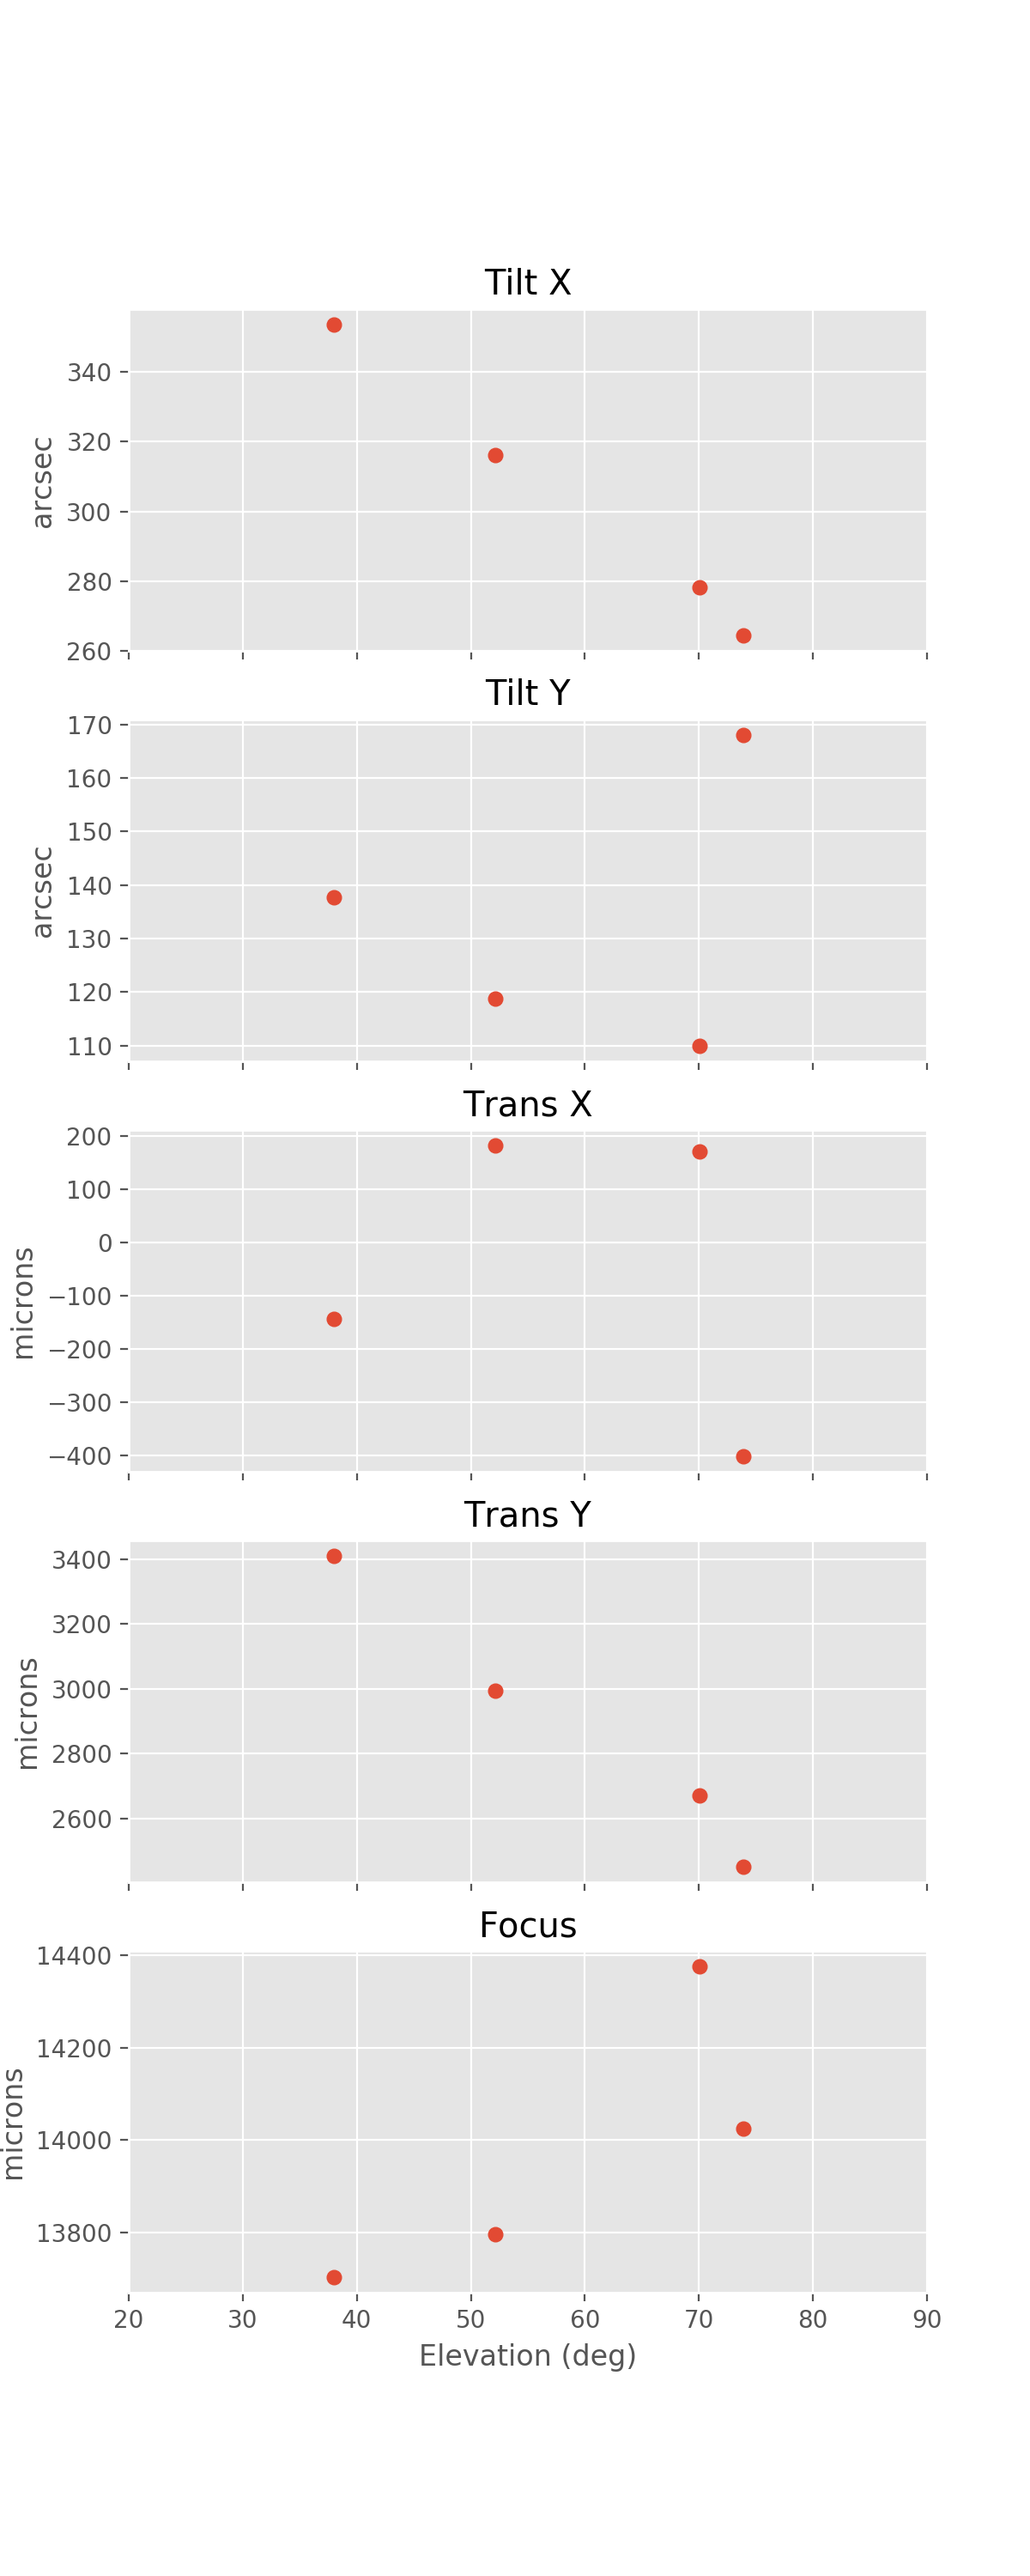

In [4]:
set1 = elcoll_read("data/ELCOLL.20171111")

elcoll_plot(set1)

Set up ``astropy.modeling`` to use a basic Levenberg-Marquardt fitter. The ``elcoll_model`` is of the form:

Hexapod(el, $T_{oss}$) = $c_0$ sin(el) + $c_1$ cos(el) + $c_2$ $T_{oss}$ + $c_3$

In [3]:
fitter = fitting.LevMarLSQFitter()
elcoll = elcoll_model()
mods = {}

In [4]:
for k in keys:
    mods[k] = fitter(elcoll, x=tot['el'], y=tot['oss'], z=tot[k])

In [5]:
elcoll_results(mods)

Tilt X: -39.54*sin(el) +128.67*cos(el) +3.13*T_oss +160.75
Tilt Y: +5.52*sin(el) +56.47*cos(el) -1.05*T_oss +110.85
Trans X: -190.26*sin(el) -599.04*cos(el) +8.82*T_oss +47.47
Trans Y: +463.36*sin(el) +1802.56*cos(el) +18.65*T_oss +582.79
Focus: +1034.03*sin(el) -25.41*cos(el) -32.70*T_oss +8866.87


<IPython.core.display.Javascript object>


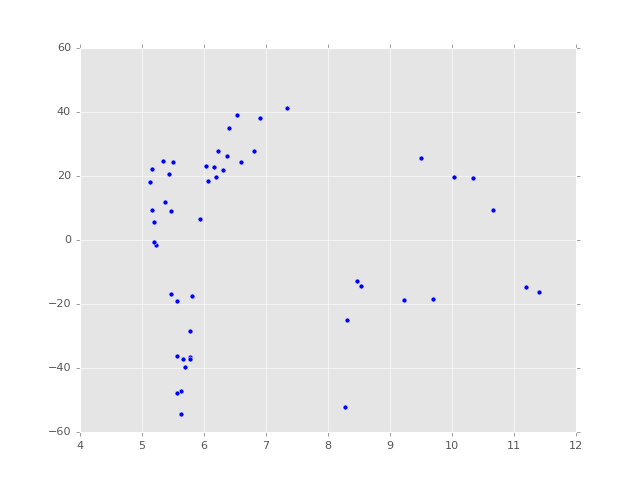

In [6]:
#plt.scatter(tot['el'], tot['focus'])
plt.scatter(tot['oss'], tot['focus'] - mods['focus'](tot['el'], tot['oss']))
plt.show()

<IPython.core.display.Javascript object>


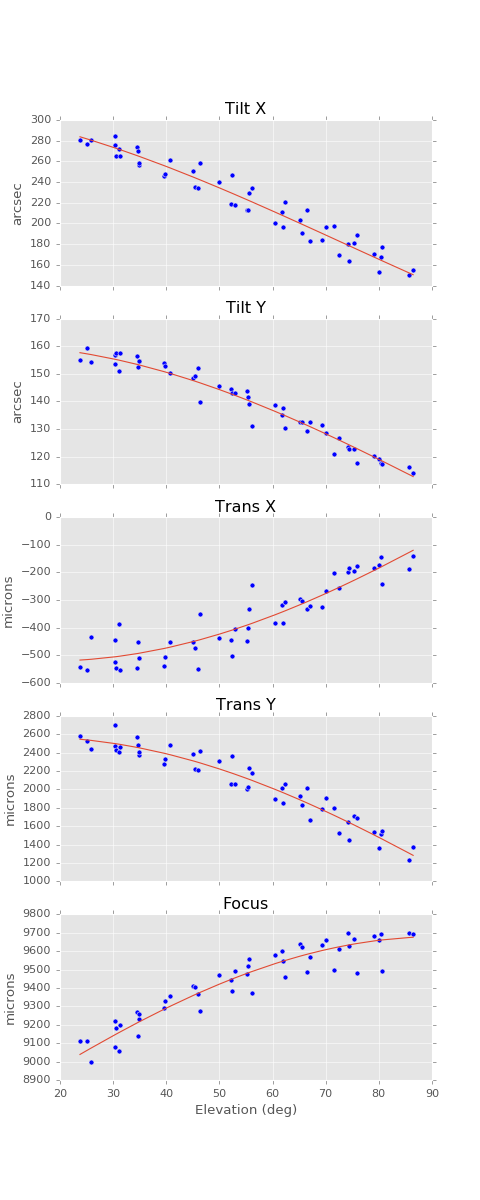

In [7]:
tot.sort('el')
elcoll_plot(tot, models=mods, mean_temp=True)

In [8]:
current = load_current_models(hexapod='f5', inst='mmirs')

In [9]:
current

{'focus': <elcoll_model(c0=671.1, c1=-286.7, c2=-13.1, c3=8498.0)>,
 'tiltx': <elcoll_model(c0=-66.1, c1=119.6, c2=0.0, c3=236.7)>,
 'tilty': <elcoll_model(c0=20.5, c1=72.0, c2=0.0, c3=70.5)>,
 'transx': <elcoll_model(c0=-507.6, c1=-947.2, c2=0.0, c3=787.7)>,
 'transy': <elcoll_model(c0=-135.8, c1=1538.0, c2=0.0, c3=1780.0)>}

In [10]:
current['tiltx'](35.0, 10.0)

<Quantity 296.7571820541593>

In [11]:
mods['tiltx'](35.0, 10.0)

<Quantity 274.7864800888785>

<IPython.core.display.Javascript object>


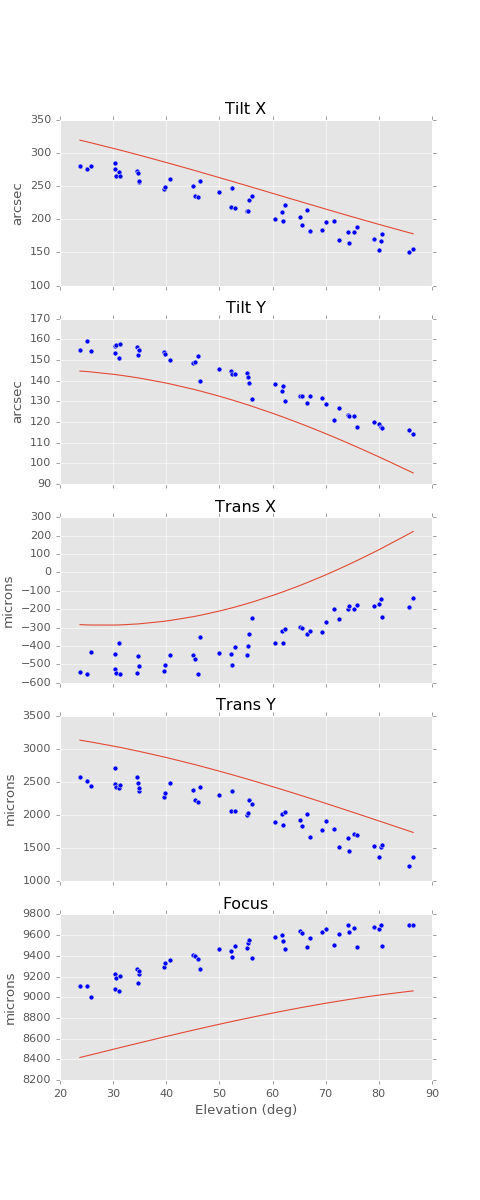

In [12]:
elcoll_plot(tot, models=current, mean_temp=True)

<IPython.core.display.Javascript object>


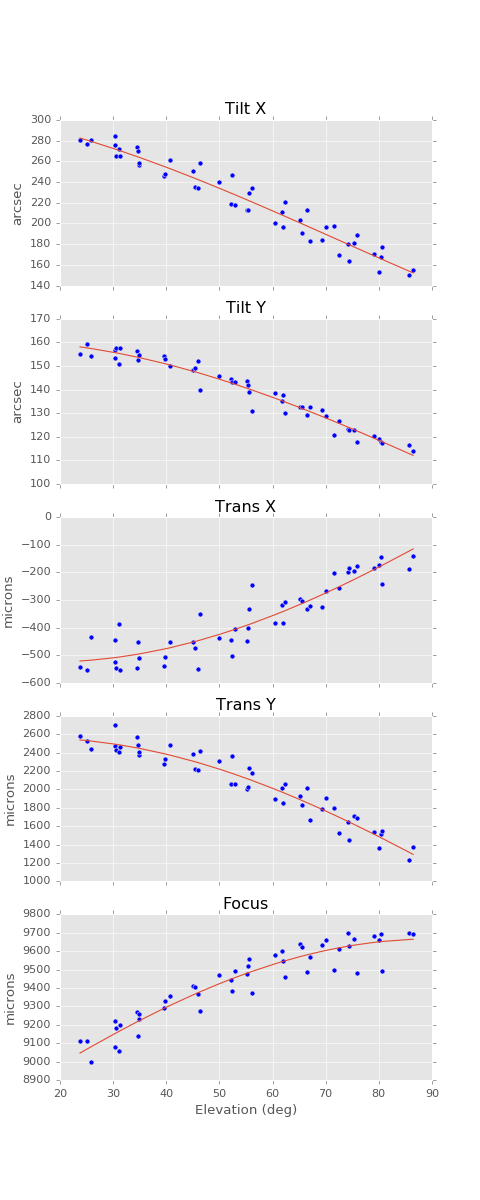

Tilt X: -40.23*sin(el) +124.72*cos(el) +0.00*T_oss +184.65
Tilt Y: +5.75*sin(el) +57.80*cos(el) +0.00*T_oss +102.84
Trans X: -192.22*sin(el) -610.16*cos(el) +0.00*T_oss +114.79
Trans Y: +459.21*sin(el) +1779.05*cos(el) +0.00*T_oss +725.11
Focus: +1038.39*sin(el) -0.71*cos(el) -13.10*T_oss +8717.31


In [13]:
# re-fit with T_oss terms fixed to current values
fix_mods = {}
for k in keys:
    elcoll.c2.value = current[k].c2.value
    elcoll.c2.fixed = True
    fix_mods[k] = fitter(elcoll, x=tot['el'], y=tot['oss'], z=tot[k])
elcoll_plot(tot, models=fix_mods, mean_temp=True)
elcoll_results(fix_mods)

Erin's end-of-run log reports the following:
```
F5 –MMIRS
X        Y       Z      Tx     Ty    Tz
39.0   2142.3  9457.1  248.7  126.8  3.1
Elevation @ 47° and Temperature @ 41°F
```
Let's see how the models compare:

In [20]:
el = 47.0
t = (41.0 - 32.0) * 5.0 / 9.0
for k, l in zip(keys, titles):
    print("%10s: %.2f" % (l, fix_mods[k](el, t)))

    Tilt X: 240.28
    Tilt Y: 146.46
   Trans X: -441.92
   Trans Y: 2274.27
     Focus: 9410.76


Looks like the Y and focus (Z) values agree pretty well, but there's a fair disagreement in the X values.  Not quite sure what this means or if it's significant.

## Summary

In a relative sense, the F/5 elcoll settings are working reasonably well, but with large zeropoint offsets.  Fixing the $T_{oss}$ terms to their current values gives the most appropriate results since the observations here didn't span a large enough range of temperature.  These results still agree well with the observations. 